In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import math
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, plot_importance

Reading the data from a csv

In [70]:
df = pd.read_csv(path, low_memory=False, nrows=178915)

In [71]:
# Cleaning the outliers from clicks

df = df[df['clicks'] <= 2.0]
df = df[df['impressions'] <= 38.5]

In [72]:
# Creating profit feature, calculated by decreasing the cost from the revenues
df['profit'] = df['revenue'] - df['cost']


# Creating profit_per_impr feature which is the profits divided by the impressions
df['profit_per_impression'] = df.profit / df.impressions


# Adding ctr feature, which is #clicks / #impressions to measure the success of the ad
df['ctr'] = df.clicks / df.impressions


# Adding cpi feature - cost per impression 
df['cpi'] = df.cost / df.impressions


# Adding the cpm feature -> (cost / impressions) * 1000
df['cpm'] = df.cpi * 1000


# Adding rev_per_impr feature, i.e. revenue per impression
df['rev_per_impr'] = df.revenue / df.impressions

# Creating a feature that holds the weekday of the event based on the date, using Python library called datetime
# Turning the dates to type datetime
df['eDate'] = [datetime.strptime(x, '%m/%d/%Y') for x in list(df['eDate'])]
# Add a column for day of the week, a number represents a day, 0 is monday, 1 is Tuesday and so on
df['Day_Of_Week'] = list(map(datetime.weekday, df['eDate']))

# 1. The RTB Problem
The problem is that we don't know for sure what will be the revenue from every impression we buy. It is not a deterministic system where we know exactly what is going to happen giving the history, so we have to model. And because it is real time and very very fast, we need algorithms for scaling, so we trade human accuracy and "control" for algo's speed and scale. 
When the accuracy of the estimation is low the targeting will be wrong and we will usually price the impression the wrong way and loose money. This is a problem we need to handle.

# 2. Exploring The Data And Some Insights

In [35]:
df.head(60)

,eDate,country,OS,networkType,deviceType,publisherCategory,advertiserCategory,productId,campaignId,rate,...,clicks,revenue,cost,profit,profit_per_impression,ctr,cpi,cpm,rev_per_impr,Day_Of_Week
0,2018-04-03,TR,ANDROID,3G,MOBILE,Video Players & Editors,Entertainment,28532956,19038398,0.008,...,0,0.0000,0.00012,-0.00012,-0.000120,0.000000,0.000120,0.120000,0.000000,1
1,2018-04-03,FR,ANDROID,3G,MOBILE,Entertainment,Entertainment,28785316,11633674,0.035,...,0,0.0000,0.01102,-0.01102,-0.002755,0.000000,0.002755,2.755000,0.000000,1
2,2018-04-01,JP,ANDROID,3G,MOBILE,NaN,GAME_ROLE_PLAYING,28542616,18795346,0.020,...,0,0.0000,0.00060,-0.00060,-0.000100,0.000000,0.000100,0.100000,0.000000,6
4,2018-04-03,ZA,ANDROID,3G,MOBILE,GAME_CARD,Entertainment,56606736,11697144,0.020,...,0,0.0000,0.00897,-0.00897,-0.004485,0.000000,0.004485,4.485000,0.000000,1
5,2018-04-03,JP,IOS,3G,MOBILE,Photo & Video,Games,42706160,16693500,0.020,...,0,0.0000,0.00301,-0.00301,-0.000430,0.000000,0.000430,0.430000,0.000000,1
6,2018-04-03,PK,ANDROID,NOT_WIFI,MOBILE,GAME_SPORTS,NaN,28533432,10815398,0.005,...,0,0.0000,0.00270,-0.00270,-0.000540,0.000000,0.000540,0.540000,0.000000,1
7,2018-04-01,FR,ANDROID,3G,MOBILE,GAME_SPORTS,Entertainment,104089852,12702512,0.040,...,0,0.0000,0.00090,-0.00090,-0.000450,0.000000,0.000450,0.450000,0.000000,6
8,2018-04-01,MY,ANDROID,3G,MOBILE,GAME_CASUAL,Entertainment,28266702,18737932,0.011,...,0,0.0000,0.00190,-0.00190,-0.000190,0.000000,0.000190,0.190000,0.000000,6
9,2018-04-02,IQ,ANDROID,WIFI,MOBILE,Social,Entertainment,28532640,13197846,0.012,...,0,0.0000,0.00021,-0.00021,-0.000070,0.000000,0.000070,0.070010,0.000000,0
10,2018-04-01,ES,ANDROID,3G,MOBILE,GAME_SIMULATION,Entertainment,71034450,16706226,0.016,...,2,0.0384,0.02277,0.01563,0.001737,0.222222,0.002530,2.530000,0.004267,6


In [37]:
df.describe()

,productId,campaignId,rate,impressions,clicks,revenue,cost,profit,profit_per_impression,ctr,cpi,cpm,rev_per_impr,Day_Of_Week
count,1.482970e+05,1.482970e+05,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000,148297.000000
mean,5.044084e+07,1.653108e+07,0.042061,6.078188,0.166666,0.006211,0.006340,-0.000129,0.000282,0.043018,0.001359,1.358760,0.001641,2.235750
std,2.685376e+07,3.708997e+06,0.072419,7.672946,0.442358,0.032996,0.020243,0.030484,0.011846,0.158976,0.003083,3.083351,0.012400,2.553668
min,2.930825e+06,9.176900e+04,0.003000,1.000000,0.000000,0.000000,0.000000,-0.895280,-0.097470,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.866385e+07,1.565558e+07,0.014000,1.000000,0.000000,0.000000,0.000330,-0.002970,-0.001080,0.000000,0.000100,0.100000,0.000000,0.000000
50%,4.122762e+07,1.844715e+07,0.020000,3.000000,0.000000,0.000000,0.001350,-0.000820,-0.000190,0.000000,0.000420,0.420000,0.000000,1.000000
75%,6.329236e+07,1.893190e+07,0.027000,7.000000,0.000000,0.000000,0.004490,-0.000130,-0.000070,0.000000,0.001460,1.460000,0.000000,6.000000
max,1.151643e+08,1.987878e+07,0.500000,38.000000,2.000000,0.900000,1.077660,0.841420,0.447000,1.000000,0.097470,97.470000,0.450000,6.000000


In [38]:
print df.impressions.median()
print df.clicks.median()
print df.clicks.quantile(0.95)
print df.impressions.quantile(0.95)

3.0
0.0
1.0
24.0


In [39]:
df.sort_values(by='productId').head()

,eDate,country,OS,networkType,deviceType,publisherCategory,advertiserCategory,productId,campaignId,rate,...,clicks,revenue,cost,profit,profit_per_impression,ctr,cpi,cpm,rev_per_impr,Day_Of_Week
101257,2018-04-02,MY,IOS,3G,MOBILE,Reference,Photo & Video,2930825,18980326,0.027,...,0,0.0,0.00314,-0.00314,-0.000116,0.0,0.000116,0.116296,0.0,0
68351,2018-04-03,MY,IOS,3G,MOBILE,Reference,Photo & Video,2930825,18980328,0.025,...,0,0.0,0.00467,-0.00467,-0.000123,0.0,0.000123,0.122895,0.0,1
83475,2018-04-02,MY,IOS,3G,MOBILE,Reference,Photo & Video,2930825,18980328,0.025,...,0,0.0,0.00370,-0.00370,-0.000112,0.0,0.000112,0.112121,0.0,0
76015,2018-04-01,MY,IOS,3G,MOBILE,Reference,Photo & Video,2930825,18980328,0.025,...,0,0.0,0.00340,-0.00340,-0.000100,0.0,0.000100,0.100000,0.0,6
21862,2018-04-01,MY,IOS,3G,MOBILE,Reference,Photo & Video,2930825,18980326,0.027,...,0,0.0,0.00120,-0.00120,-0.000100,0.0,0.000100,0.100000,0.0,6


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148297 entries, 0 to 178914
Data columns (total 22 columns):
eDate                    148297 non-null datetime64[ns]
country                  148297 non-null object
OS                       148297 non-null object
networkType              148297 non-null object
deviceType               148297 non-null object
publisherCategory        128777 non-null object
advertiserCategory       132309 non-null object
productId                148297 non-null int64
campaignId               148297 non-null int64
rate                     148297 non-null float64
advMaturity              148277 non-null object
impressions              148297 non-null int64
clicks                   148297 non-null int64
revenue                  148297 non-null float64
cost                     148297 non-null float64
profit                   148297 non-null float64
profit_per_impression    148297 non-null float64
ctr                      148297 non-null float64
cpi            

Like we can see, we have some missing values (NULL) in 'publisherCategory', 'advertiserCategory' and 'advMaturity' features - I will take care of that when I'll model

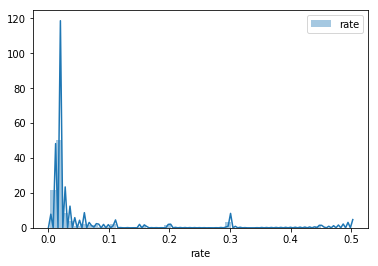

In [42]:
# Plotting the distribution of imprssions
sns.distplot(df['rate'])
plt.legend(['rate'])
plt.show()

In [ ]:
# Plotting the distribution of imprssions
df_c = df[df['clicks'] < 40]
sns.distplot(df_c['clicks'])
plt.legend(['clicks'])
plt.show()

In [ ]:
print sum(df.profit)

In [46]:
# Counting how many observations we have for each devise
df.groupby('deviceType').count()['eDate']

deviceType
MOBILE    140454
TABLET      7843
Name: eDate, dtype: int64

Like we can see, we have 170,094 of the devices are mobile type, and 8,821 are tablets

In [47]:
df.eDate.unique()

array(['2018-04-03T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-04-02T00:00:00.000000000'], dtype='datetime64[ns]')

We look at three dates, 4/1, 4/2 and 4/3 of 2018

In [48]:
countries = df.country.unique()
print countries
print 'Number of countries is:', len(countries)

['TR' 'FR' 'JP' 'ZA' 'PK' 'MY' 'IQ' 'ES' 'TW' 'GB' 'AT' 'KR' 'PL' 'US'
 'MM' 'QA' 'DE' 'RU' 'MX' 'CH' 'SE' 'TN' 'AU' 'PT' 'KW' 'AE' 'BD' 'SG'
 'SN' 'DK' 'EG' 'NG' 'KH' 'IN' 'ID' 'BR' 'HK' 'SA' 'OM' 'NO' 'NP' 'IT'
 'FI' 'MA' 'NZ' 'CZ' 'SI' 'SK' 'PH' 'KZ' 'RS' 'BH' 'PY' 'VN' 'HR' 'GR'
 'CA' 'NL']
Number of countries is: 58


In [50]:
print 'There are',  df.productId.unique().size, 'unique apps.'

There are 8598 unique apps.


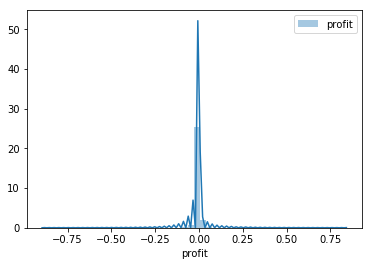

Total profit mean: -0.000129467945205
Total profit median: -0.00082
Max profit is: 0.84142
Min profit is: -0.89528
std: 0.0304841189614

Avg profit for mobiles: -0.000123158688325
The median for mobiles is: -0.00083

Avg profit for tablets: -0.000242455369119
The median for tablets is: -0.00074


In [52]:
# Plotting the distribution of profit
sns.distplot(df['profit'])
plt.legend(['profit'])
plt.show()
print "Total profit mean:", df['profit'].mean()
print "Total profit median:", df['profit'].median()
print 'Max profit is:', max(df['profit'])
print 'Min profit is:', min(df['profit'])
print "std:", df['profit'].std()
print

# Now we look for profit for each devise
df_mobile = df[df['deviceType'] == 'MOBILE']
df_tablet = df[df['deviceType'] == 'TABLET']

# For mobile
print "Avg profit for mobiles:", df_mobile.profit.mean()
print "The median for mobiles is:", df_mobile.profit.median()
print
# For tablet
print "Avg profit for tablets:", df_tablet.profit.mean()
print "The median for tablets is:", df_tablet.profit.median()

In [53]:
print "There are", len(df.publisherCategory.unique()), "publisher categories compared to", len(df.advertiserCategory.unique()), "advertiser categories"

There are 60 publisher categories compared to 46 advertiser categories


In [54]:
# Impressions Analysis 
num_of_imp = df.impressions.sum()
num_of_clicks = df.clicks.sum()
print "Total number of impressions is", num_of_imp, "total number of clicks is", num_of_clicks, "and there are", float(num_of_imp)/float(num_of_clicks), "impressions per click"

Total number of impressions is 901377 total number of clicks is 24716 and there are 36.4693720667 impressions per click


In [ ]:
# Let's take the 5 highest publisher categories by avg ctr 
print 'Top 5 by ctr:'
print df.groupby('publisherCategory').mean().sort_values(by='ctr', ascending=False).head(5)

In [56]:
# Lets see how many clicks and impressions we get from each network

# How many networks do we have?
df.networkType.unique()

# Count by type
count_by_network = df.groupby('networkType').count()['eDate']
print 'Count of impressions by network:'
print count_by_network
count_3G = count_by_network[0]
count_WIFI = count_by_network[3]
print

sum_impressions_by_network = df.groupby('networkType').sum()['impressions']
print 'Sum of impressions by network:'
print sum_impressions_by_network
print 

print 'Impressions per connection for 3G:', sum_impressions_by_network[0] / count_3G
print 'Impressions per connection for WIFI:', sum_impressions_by_network[3] / count_WIFI
print 'Impressions per connection for WIFI:', sum_impressions_by_network[1] / count_by_network[1]
print 'Impressions per connection for WIFI:', sum_impressions_by_network[2] / count_by_network[2]

Count of impressions by network:
networkType
3G          102001
NOT_WIFI       697
UNKNOWN        463
WIFI         45136
Name: eDate, dtype: int64

Sum of impressions by network:
networkType
3G          630941
NOT_WIFI      3459
UNKNOWN       2601
WIFI        264376
Name: impressions, dtype: int64

Impressions per connection for 3G: 6
Impressions per connection for WIFI: 5
Impressions per connection for WIFI: 4
Impressions per connection for WIFI: 5


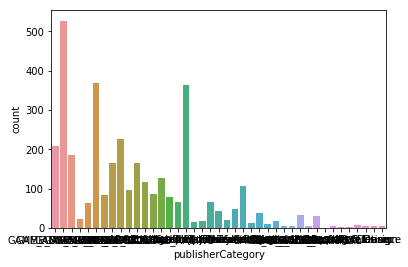

In [60]:
# Lets see for some adv category - GAME_ROLE_PLAYING the count of the publisher category
df_current = df[df['advertiserCategory'] == 'GAME_ROLE_PLAYING']
sns.countplot(x="publisherCategory", data=df_current)
plt.show()

Like we can expect, for each category (I ran more for myself) the distribution is far from even, some adv categories go well with other publisher categories and some don't. 

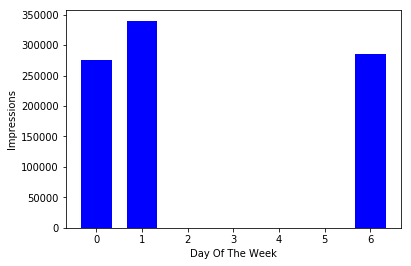

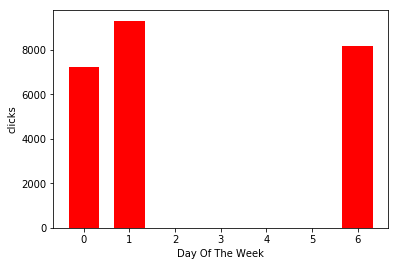

In [58]:
# Let's see how many impressions and clicks we get each day of the week (we only have data on Sunday=6, Monday=0, Tuesday=1)

# Grouping by the day of the week and sum
df_day = df.groupby("Day_Of_Week").sum()

# Impressions
bar_test = plt.bar([0, 1, 6], df_day['impressions'], 1/1.5, color="blue")
plt.ylabel('Impressions')
plt.xlabel('Day Of The Week')    
plt.show()

# Clicks
bar_test = plt.bar([0, 1, 6], df_day['clicks'], 1/1.5, color="red")
plt.ylabel('clicks')
plt.xlabel('Day Of The Week')    
plt.show()

# 3. Additionl Data I Would Want
* There are features that I needed (like profit or ctr) that I calculated above.  
* Additional data I would find useful that it is not in our database is time of the day (might has an impact on the numbers of cicks), from which website did the user come from (browsing history in general, gives better targeting) and personal data about the user (if it's even possible to have and use, also for targeting).

# 4. US campaign. Who Are The Best Publishers?

In [61]:
# Creating a new table only with US users
df_us = df[df.country == 'US']

In [62]:
# Looking for the most profitible publisher category for users from the US
print df_us.groupby('publisherCategory').sum().sort_values(by='profit', ascending=False).head(5)['profit']

publisherCategory
GAME_CARD                  6.177708
GAME_BOARD                 3.546140
GAME_PUZZLE                3.219398
Music & Audio              2.919649
Video Players & Editors    2.501580
Name: profit, dtype: float64


Like we can see, the most profitiable publisher category for US users is Personalization (3063.65) and after that is GAME_CARD (229.26)

In [63]:
# Looking for the top publisher category by average profits for users from the US
print df_us.groupby('publisherCategory').mean().sort_values(by='profit', ascending=False).head(5)['profit']

publisherCategory
House & Home               0.023771
News & Magazines           0.020055
Video Players & Editors    0.019854
GAME_BOARD                 0.017910
GAME_ADVENTURE             0.013860
Name: profit, dtype: float64


Like we can see, the top publisher category by average profit for US users is Personalization (18.56) and after that is Shopping (0.71). GAME_CARD is third (0.39).

Until now, the best publisher category in terms of profits is **Personalization**

In [64]:
# Looking for the top publisher categories by average ctr for users from the US
print df_us.groupby('publisherCategory').mean().sort_values(by='ctr', ascending=False).head(5)['ctr']

publisherCategory
GAME_ADVENTURE     0.144767
GAME_CASINO        0.090909
GAME_SPORTS        0.090082
GAME_SIMULATION    0.088308
GAME_RACING        0.087166
Name: ctr, dtype: float64


By average ctr the top categories are in the game domain when GAME_ADVENTURE is number one (0.175) when after comes GAME_CASINO with (0.104)

Now let's say we have confidence that our campaign will produce great ctr, where is the largest US traffic proportion? let's find the publisher categories with the highest number of impressions:

In [65]:
# Looking for the top publisher categories by avergae number of impressions for users from the US
print df_us.groupby('publisherCategory').mean().sort_values(by='impressions', ascending=False).head(5)[['impressions', 'profit', 'ctr']]

                   impressions    profit       ctr
publisherCategory                                 
Libraries & Demo     12.277778 -0.004855  0.000000
Parenting            11.000000 -0.000220  0.000000
Comics                8.200000 -0.001670  0.000000
Personalization       7.495935 -0.013889  0.028245
Photography           7.294798  0.011691  0.020640


Like we can see, the top publisher category by avg number of impressions is Education but, it is not profitiable. On the other hand, the two categories right after, Shopping and Personalization, are profitiable. This strengthes the conclusion the we should focus on the **Personalization** category.   

In [66]:
# Now let's find the most profitiable app (productId)
df_us.groupby('productId').sum().sort_values(by='profit', ascending=False).head(10)

,campaignId,rate,impressions,clicks,revenue,cost,profit,profit_per_impression,ctr,cpi,cpm,rev_per_impr,Day_Of_Week
productId,,,,,,,,,,,,,
32383258,234843284,3.403,59,6,2.40,1.01335,1.38665,0.538310,1.790909,0.223963,223.963067,0.762273,45
48182746,140127752,2.700,19,5,1.80,0.45168,1.34832,0.644866,2.366667,0.190134,190.134065,0.835000,20
28266566,250924382,4.050,174,7,2.44,1.16744,1.27256,0.060781,0.534295,0.084016,84.015923,0.144797,29
28266778,176922360,3.630,137,7,2.40,1.17194,1.22806,0.119343,0.570366,0.102903,102.903039,0.222246,28
48182292,210189528,4.500,64,5,1.65,0.44576,1.20424,0.523816,1.503846,0.077338,77.337775,0.601154,28
28187750,159408316,2.880,21,5,1.68,0.54608,1.13392,0.775689,2.833333,0.239311,239.311343,1.015000,26
28532998,160456516,3.080,137,8,2.63,1.53098,1.09902,0.059910,0.668194,0.088035,88.034886,0.147944,27
28266892,122610908,2.550,21,4,1.50,0.45025,1.04975,0.523341,1.583333,0.151659,151.659170,0.675000,19
71699272,90396140,0.980,6,4,1.20,0.15132,1.04868,0.782300,3.000000,0.117700,117.700000,0.900000,19


It's very important noting that it also depends on more stuff such as the **category of the ad**. In the question it was referred to to campaigns in plural so I put less emphasize on that, but given an ad category, I would output the best publisher categories with regards to that. For example let's take 'Games' as the ad category: 

In [67]:
df_us_games = df_us[df_us['advertiserCategory'] == 'Games']  # Filtering for Games adv category only
df_us_games.groupby('publisherCategory').sum().sort_values(by='profit', ascending=False).head(5)['profit']

publisherCategory
News                0.95335
Music               0.45483
Food & Drink        0.16214
Utilities           0.11442
Libraries & Demo   -0.00034
Name: profit, dtype: float64

Like we can see, the most profitiable publisher category for american people when the ad is in the game category is News.

**To conclude,** it depends on the requested data that we recieve, but when we only look for the best publisehrs for US users, we will see which features such as publisher category, date, device and so on work best for american users using metrics like profits but also clicks or traffic. 

# 5. Negative ROI, why?
ROI is negative when cost is greater than the revenue. Why is that? Possible reasons:
* **Wrong pricing** - Can be caused by weak analysis and modeling. If we bid for a single impression, wrong estimation of ctr will cause wrong estimation of revenue and wrong pricing that might cause us to pay more than we should (or less than we should and then loose a porfitiable impression at the acution)
* Technical or design preblems 

# 6. Monitoring The Revenue
I would run a script (we can scheduele the script to run automatically and permanetly in a time we set and even send the result to our emails). 

For example if we want to see every day yesterday's total revenue and the database server is mysql, we can use mySqlLdb (an interface for connecting python to mysql server) and extract what we want using the following query: SELECT SUM(revenue) FROM RTB_table WHERE eDate = yesterday. 

The yesterday date would be calculated with datetime library as follows: yesterday = datetime.now() - timedelta(days=1)

We used the revenue and eDate metrics. 

# 7. Modeling
In this section I will suggest an algorithm to estimate the best bid based on historical data.

Background:
Given a new request, or an impression offered, we need to find the bid amount that will give us the highest profit for this impression. I will build a model that given the request data will estimate the ctr and from that we will calculte the revenue. According to the expected revenue we can place the right bid.
First step will be to estimate how many clicks I will get for this impression, or more accurately, the click-through rate (ctr). After estimate that, I can multiply my prediction with the given rate and receive the predicted revenue. 

**Preprocessing the data:**

In [11]:
# Fill the missing values
most_freq = df['publisherCategory'].value_counts().idxmax()
df['publisherCategory'] = df['publisherCategory'].fillna(most_freq)

most_freq_adv = df['advertiserCategory'].value_counts().idxmax()
df['advertiserCategory'] = df['advertiserCategory'].fillna(most_freq_adv)

most_freq_mat = df['advMaturity'].value_counts().idxmax()
df['advMaturity'] = df['advMaturity'].fillna(most_freq_adv)

I had an idea of filling the missing values by creating a list of triples for every row: (publisherCategory, advertiserCategory, advMaturity) and lets say I have a missing value in advMaturity, I'll check what is publisherCategory and advertiserCategory and look what is the most frequent triple with these two and by that fill the third but I had a memory error when trying to do it so I took the more simple approach. The idea is that these categories are connected, you expect to see some categories go with a certain group that some aren't. For example you would expect to see 'GAME SPORT' ad category with 'sports' publisher category.

In [12]:
# Changing these features to type Categories, in order to make them readable for the model
df['country'] = df['country'].astype('category').cat.codes
df['OS'] = df['OS'].astype('category').cat.codes
df['networkType'] = df['networkType'].astype('category').cat.codes
df['deviceType'] = df['deviceType'].astype('category').cat.codes
df['publisherCategory'] = df['publisherCategory'].astype('category').cat.codes
df['advertiserCategory'] = df['advertiserCategory'].astype('category').cat.codes
df['advMaturity'] = df['advMaturity'].astype('category').cat.codes

In [13]:
df.head()

,eDate,country,OS,networkType,deviceType,publisherCategory,advertiserCategory,productId,campaignId,rate,...,clicks,revenue,cost,profit,profit_per_impression,ctr,cpi,cpm,rev_per_impr,Day_Of_Week
0,2018-04-03,53,0,0,0,57,5,28532956,19038398,0.008,...,0,0.0,0.00012,-0.00012,-0.000120,0.0,0.000120,0.120,0.0,1
1,2018-04-03,14,0,0,0,10,5,28785316,11633674,0.035,...,0,0.0,0.01102,-0.01102,-0.002755,0.0,0.002755,2.755,0.0,1
2,2018-04-01,23,0,0,0,30,18,28542616,18795346,0.020,...,0,0.0,0.00060,-0.00060,-0.000100,0.0,0.000100,0.100,0.0,6
4,2018-04-03,57,0,0,0,17,5,56606736,11697144,0.020,...,0,0.0,0.00897,-0.00897,-0.004485,0.0,0.004485,4.485,0.0,1
5,2018-04-03,23,1,0,0,45,22,42706160,16693500,0.020,...,0,0.0,0.00301,-0.00301,-0.000430,0.0,0.000430,0.430,0.0,1


In [14]:
# Choosing the attributes I want to model with
df_to_model = df[['ctr', 'country', 'OS', 'networkType', 'deviceType', 'publisherCategory', 'advertiserCategory', 'advMaturity', 
                 'Day_Of_Week']]
print len(df_to_model)
print df_to_model.head()

# Spliting the data to train and test sets
x=df_to_model.drop('ctr',axis=1).values
y=df_to_model['ctr'].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.0,random_state=21)
y_train = np.array(y_train)
y_test = np.array(y_test)

148297
   ctr  country  OS  networkType  deviceType  publisherCategory  \
0  0.0       53   0            0           0                 57   
1  0.0       14   0            0           0                 10   
2  0.0       23   0            0           0                 30   
4  0.0       57   0            0           0                 17   
5  0.0       23   1            0           0                 45   

   advertiserCategory  advMaturity  Day_Of_Week  
0                   5            8            1  
1                   5            8            1  
2                  18           13            6  
4                   5            8            1  
5                  22            2            1  


I chose to use knn regressor (http://www.saedsayad.com/k_nearest_neighbors_reg.htm) because I needed a regression algorithm (the output is a real number) and the knn worked best from the ones I tried. I choose k=30 after test looping through a range of k's and 30 gave me the best result. 

**Training:**

In [ ]:
# knn regressor
neigh = KNeighborsRegressor(n_neighbors=1, weights='distance')
neigh.fit(x, y) 

**testing the algo's validity**

I will do it with the score function that return the coefficient of determination (R^2) that gives us a measure of the error, or, how well the model works. The training score is for the data set that we train the model on, the test score is for the portion of the dataset that the model didn't "see" while training and it is for testing the model on completely new data. Also, I put some exapmles for the predicted revenues next to the actual revenues in order to compare with our eyes how close they are.  

In [ ]:
neigh_score_train = neigh.score(x, y)
print('Training score: ',neigh_score_train)
neigh_score_test = neigh.score(x_test, y_test)
print('Testing score: ',neigh_score_test)

In [ ]:
prediction_arr = neigh.predict(np.array(df[['country', 'OS', 'networkType', 'deviceType', 'publisherCategory', 
                                            'advertiserCategory', 'advMaturity', 'Day_Of_Week']]))


# What is the score of the whole dataset:
neigh_score = neigh.score(x, y)
print "score of the whole dataset:", neigh_score

df['predicted_ctr'] = prediction_arr
df['pred_revenue'] = df.predicted_ctr * df.impressions * df.rate
print df.head(20)[['pred_revenue', 'revenue']]

**How we would bid:**
Let's say I bid for the impression at index 18. I estimated that the revenue will be 0.643, I take a safe range and pricing according to 0.5. Let's say I want 30% margins, so I place a bid of 0.5*1.3 = 0.65 (research showed that in second price option the best strategy is to bid the amount that we actually want to pay). I'll do it for every impression. As more data flows into the system we can improve the accuracy of the model by keep training it. 

I used nothing but Python and its libraries mentioned at the top of the page. All the code is here in this file

# lightGBM Modeling

In [15]:
df_train = df[:120000]
df_test = df[120000:]

df_train_set, df_val_set = train_test_split(df_train, test_size=0.25, random_state=1989)

features = ['country', 'OS', 'networkType', 'deviceType', 'publisherCategory', 
                                            'advertiserCategory', 'advMaturity', 'Day_Of_Week']

In [16]:
lgb = LGBMRegressor(n_estimators=10**4, max_depth=9, colsample_bytree=0.7, subsample=0.9, learning_rate=0.5)
lgb.fit(df_train_set[features], df_train_set['ctr'], 
        eval_set=[(df_train_set[features], df_train_set['ctr']), 
                  (df_val_set[features], df_val_set['ctr'])], 
        verbose=100, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[11]	valid_0's l2: 0.0245361	valid_1's l2: 0.0245366


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       learning_rate=0.5, max_depth=9, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1)

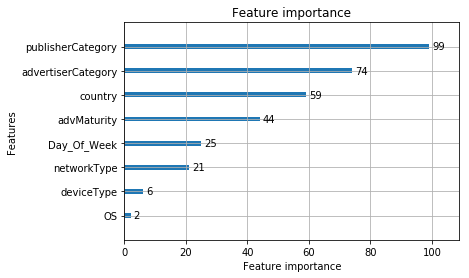

In [17]:
plot_importance(lgb)

We will take out device type and OS

In [18]:
df_train['ctr_pred'] = lgb.predict(df_train[features])
df_test['ctr_pred'] = lgb.predict(df_test[features])

C:\Users\lenove\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\lenove\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
print (df_train['ctr'] - df_train['ctr_pred']).abs().mean()
print (df_test['ctr'] - df_test['ctr_pred']).abs().mean()

0.0715342464329
0.0717726272868


In [20]:
features2 = ['country', 'publisherCategory', 'advertiserCategory', 'advMaturity']

In [21]:
lgb = LGBMRegressor(n_estimators=10**4, max_depth=9, colsample_bytree=0.7, subsample=0.9, learning_rate=0.5)
lgb.fit(df_train_set[features2], df_train_set['ctr'], 
        eval_set=[(df_train_set[features2], df_train_set['ctr']), 
                  (df_val_set[features2], df_val_set['ctr'])], 
        verbose=100, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[23]	valid_0's l2: 0.0245642	valid_1's l2: 0.0245367


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       learning_rate=0.5, max_depth=9, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1)

In [22]:
df_train['ctr_pred'] = lgb.predict(df_train[features2])
df_test['ctr_pred'] = lgb.predict(df_test[features2])

# Negative cannot happen, so every negative prediciton map it to zero
df_train['ctr_pred'] = [n if n >= 0 else 0 for n in df_train['ctr_pred']]
df_test['ctr_pred'] = [n if n >= 0 else 0 for n in df_test['ctr_pred']]


C:\Users\lenove\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\lenove\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lenove\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [23]:
print (df_train['ctr'] - df_train['ctr_pred']).abs().mean()
print (df_test['ctr'] - df_test['ctr_pred']).abs().mean()

0.0715220870375
0.071759740907


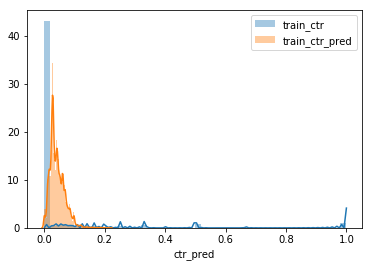

In [24]:
sns.distplot(df_train['ctr'])
sns.distplot(df_train['ctr_pred'])

plt.legend(['train_ctr', 'train_ctr_pred'])

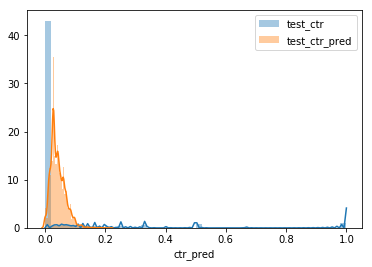

In [25]:
sns.distplot(df_test['ctr'])
sns.distplot(df_test['ctr_pred'])

plt.legend(['test_ctr', 'test_ctr_pred'])

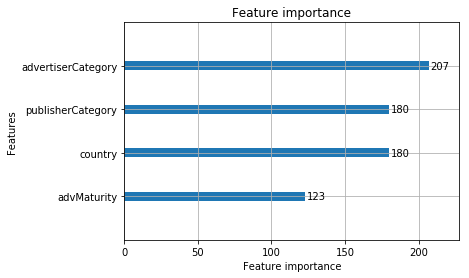

In [26]:
plot_importance(lgb)

In [27]:
df_pred_actual = df_test[['ctr', 'ctr_pred']]
df_pred_actual.head(30)

,ctr,ctr_pred
144730,0.250000,0.074680
144731,0.000000,0.061213
144732,0.125000,0.031146
144733,0.000000,0.066200
144734,0.000000,0.030764
144735,0.000000,0.044650
144736,0.000000,0.035714
144737,0.250000,0.044591
144738,0.000000,0.069411
144739,0.027778,0.060351


# Results Summary
I used another algorithms called lightGBM that supposed to be more accurate and has a built in function that let me know which features are important and which are noise. 
I evaluated the accuracy with calculating the average error of the predictions. I also plotted it. 


# Lior Katz